# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

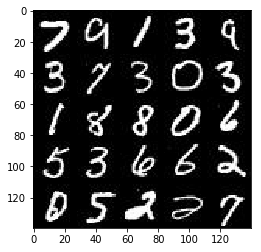

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

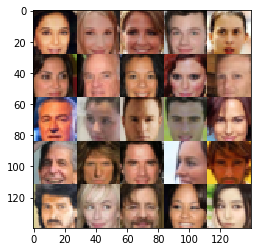

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, (None), name='learning_rate')
    
    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [24]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 56, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(x1, x1*alpha)
#         print(x1.get_shape())
        
        x2 = tf.layers.conv2d(x1, 112, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2, x2*alpha)
#         print(x2.get_shape())
        
        x3 = tf.layers.conv2d(x2, 224, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(x3, x3*alpha)
#         print(x3.get_shape())
        
        flat = tf.reshape(x3, (-1, 4*4*224))
        
        logits = tf.layers.dense(flat, 1)
#         print(logits.get_shape())
        
        out = tf.sigmoid(logits)
#         out = tf.nn.dropout(out, keep_prob=0.99)
        
        return out, logits
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [25]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 3*3*512)
        
        x1 = tf.reshape(x1, (-1,3,3,512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(x1, x1 * alpha)
#         print(x1.get_shape())
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='valid',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(x2, x2 * alpha)
#         print(x2.get_shape())
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(x3, x3 * alpha)
#         print(x3.get_shape())
        
        x4 = tf.layers.conv2d_transpose(x3, 128, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(x4, x4 * alpha)
#         print(x4.get_shape())
        
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
#         print(logits.get_shape())
        
        out = tf.tanh(logits)
#         out = tf.nn.dropout(out, keep_prob=0.99)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.9
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)*smooth))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    
#     sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    show_every = 100
    print_every = 10
    step = 0
    samples, losses = [], []
    
    img_height = data_shape[1]
    img_width = data_shape[2]
    img_depth = data_shape[3]
    
    input_real, input_z, lr = model_inputs(img_height, img_width, img_depth, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    
    with tf.Session() as sess:
        
        sess.run(tf.global_variables_initializer())
        show_generator_output(sess, 25, input_z, img_depth, data_image_mode)
        saver = tf.train.Saver()
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                
                batch_images = batch_images * 2
                
                batch_z = np.random.uniform(-1,1, size=(batch_size, z_dim))
                
                # show image at start
                
                
                _ = sess.run(d_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                

                
                if step % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if step % show_every == 0:
                    show_generator_output(sess, 25, input_z, img_depth, data_image_mode)
                
        saver.save(sess, './checkpoints/generator.ckpt')       
                
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [15]:
!mkdir 'checkpoints'

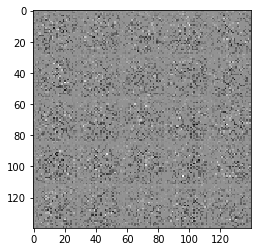

Epoch 1/2... Discriminator Loss: 0.6594... Generator Loss: 1.6687
Epoch 1/2... Discriminator Loss: 0.4104... Generator Loss: 2.6258
Epoch 1/2... Discriminator Loss: 0.3760... Generator Loss: 3.2768
Epoch 1/2... Discriminator Loss: 0.3641... Generator Loss: 3.4958
Epoch 1/2... Discriminator Loss: 0.3474... Generator Loss: 3.8112


KeyboardInterrupt: 

In [16]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

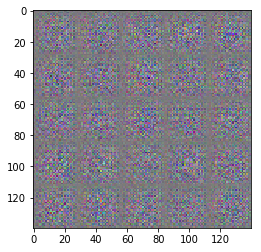

Epoch 1/1... Discriminator Loss: 4.3399... Generator Loss: 0.3517
Epoch 1/1... Discriminator Loss: 3.2757... Generator Loss: 0.3559
Epoch 1/1... Discriminator Loss: 1.3239... Generator Loss: 0.9114
Epoch 1/1... Discriminator Loss: 3.0284... Generator Loss: 0.4121
Epoch 1/1... Discriminator Loss: 1.5696... Generator Loss: 0.7365
Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 0.8919
Epoch 1/1... Discriminator Loss: 1.9541... Generator Loss: 0.4086
Epoch 1/1... Discriminator Loss: 1.0791... Generator Loss: 1.5740
Epoch 1/1... Discriminator Loss: 0.8253... Generator Loss: 1.4180
Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 2.4114


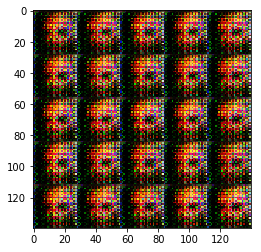

Epoch 1/1... Discriminator Loss: 0.7126... Generator Loss: 1.8759
Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 0.9623
Epoch 1/1... Discriminator Loss: 1.5386... Generator Loss: 0.9168
Epoch 1/1... Discriminator Loss: 0.6316... Generator Loss: 1.7669
Epoch 1/1... Discriminator Loss: 0.7611... Generator Loss: 1.6701
Epoch 1/1... Discriminator Loss: 0.8397... Generator Loss: 1.2696
Epoch 1/1... Discriminator Loss: 0.8152... Generator Loss: 1.2353
Epoch 1/1... Discriminator Loss: 0.6741... Generator Loss: 1.6722
Epoch 1/1... Discriminator Loss: 0.6244... Generator Loss: 1.6051
Epoch 1/1... Discriminator Loss: 1.7118... Generator Loss: 0.6473


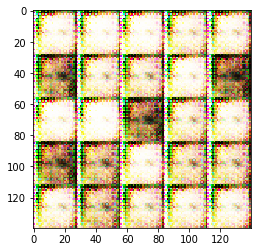

Epoch 1/1... Discriminator Loss: 1.7143... Generator Loss: 0.6362
Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 1.1201
Epoch 1/1... Discriminator Loss: 1.5566... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.7434... Generator Loss: 0.5910
Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.8068
Epoch 1/1... Discriminator Loss: 1.5193... Generator Loss: 0.6567
Epoch 1/1... Discriminator Loss: 1.1376... Generator Loss: 1.1713
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.0872... Generator Loss: 1.3010


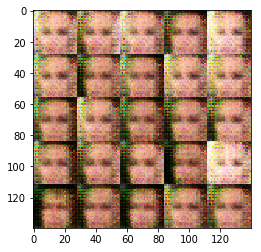

Epoch 1/1... Discriminator Loss: 1.7887... Generator Loss: 0.6585
Epoch 1/1... Discriminator Loss: 2.2519... Generator Loss: 0.4233
Epoch 1/1... Discriminator Loss: 1.7268... Generator Loss: 0.6234
Epoch 1/1... Discriminator Loss: 1.5516... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.5818... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 1.5727... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.4949... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.6273... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 1.5586... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 1.4851... Generator Loss: 0.6281


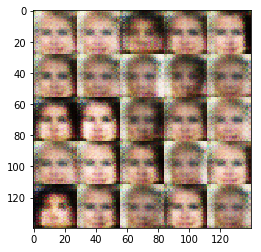

Epoch 1/1... Discriminator Loss: 1.7570... Generator Loss: 0.5685
Epoch 1/1... Discriminator Loss: 1.6169... Generator Loss: 0.5986
Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 0.7135
Epoch 1/1... Discriminator Loss: 1.4811... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.6077... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.5255... Generator Loss: 0.6696
Epoch 1/1... Discriminator Loss: 1.5600... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 1.5264... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 1.5399... Generator Loss: 0.6950


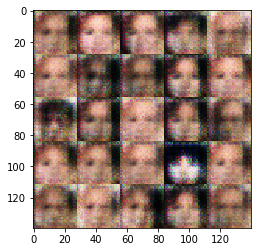

Epoch 1/1... Discriminator Loss: 1.5662... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 1.6384... Generator Loss: 0.6079
Epoch 1/1... Discriminator Loss: 1.4946... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.5271... Generator Loss: 0.6461
Epoch 1/1... Discriminator Loss: 1.4685... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.6593... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 1.5375... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.5560... Generator Loss: 0.6569


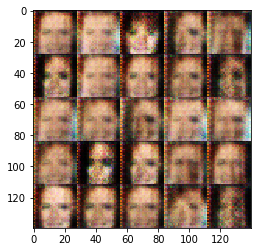

Epoch 1/1... Discriminator Loss: 1.4784... Generator Loss: 0.7062
Epoch 1/1... Discriminator Loss: 1.5004... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.5931... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 1.5161... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 1.5387... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 1.5360... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.7351


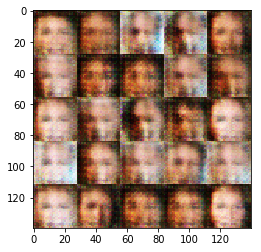

Epoch 1/1... Discriminator Loss: 1.4689... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.5046... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.6122... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 1.4894... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.4484... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.5269... Generator Loss: 0.6578


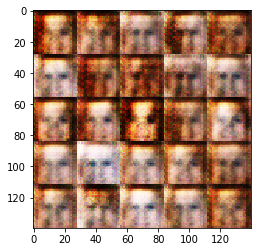

Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 0.8274
Epoch 1/1... Discriminator Loss: 1.4977... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.7617
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.7711


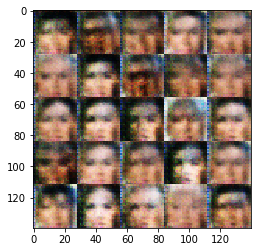

Epoch 1/1... Discriminator Loss: 1.4709... Generator Loss: 0.6765
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.4806... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.7099
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.5750... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.7366


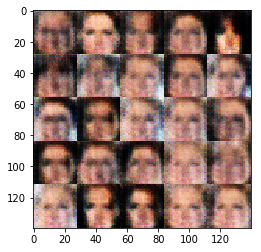

Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.4869... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 0.7326
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.7461
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.7379


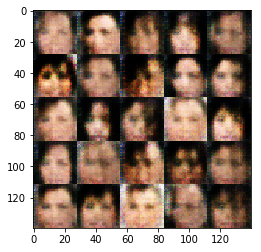

Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.7092
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.7283
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.4830... Generator Loss: 0.6813
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.4761... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.7424


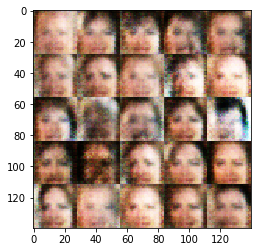

Epoch 1/1... Discriminator Loss: 1.4905... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.7532
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.4953... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.6985


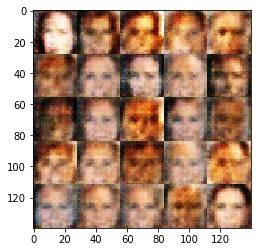

Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 1.4766... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.7283
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.7474


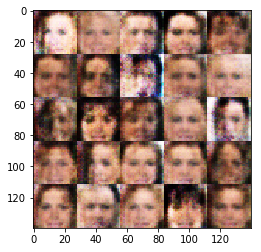

Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.7284


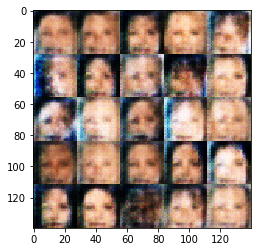

Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.4769... Generator Loss: 0.7242
Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.4791... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.7003


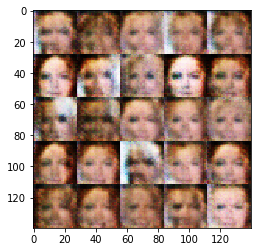

Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 1.4896... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.7530
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.4770... Generator Loss: 0.6981
Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.7710


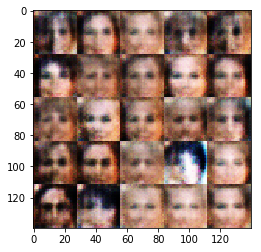

Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.7139
Epoch 1/1... Discriminator Loss: 1.4549... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.5050... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 0.6946


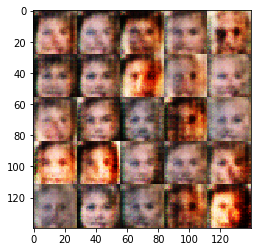

Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.7791
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.8173
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.7231
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.7327


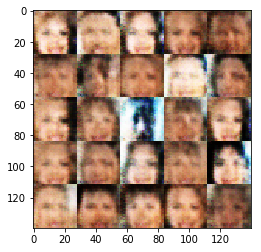

Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.7206


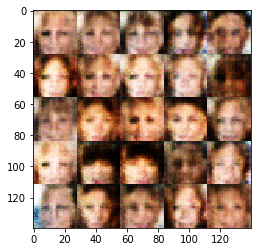

Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.4658... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.7605


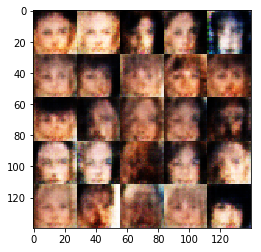

Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.7219
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.7470


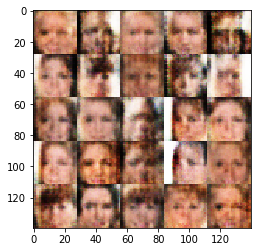

Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.7472


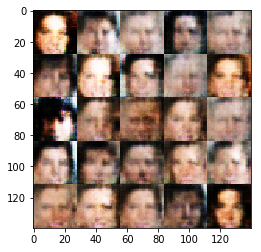

Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.8028
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.7810
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7649


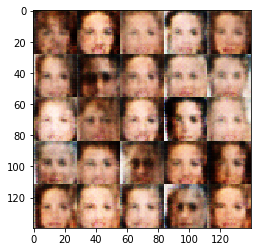

Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.7665


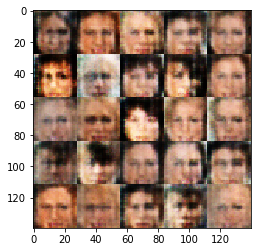

Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.4776... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.7267


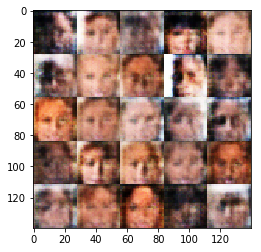

Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.7158
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.7269
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 1.4553... Generator Loss: 0.6966


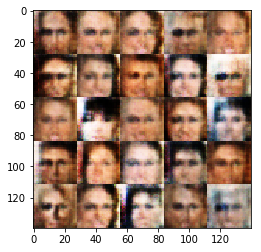

Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.7615


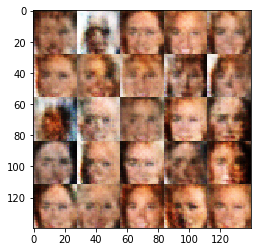

Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.4416... Generator Loss: 0.6931


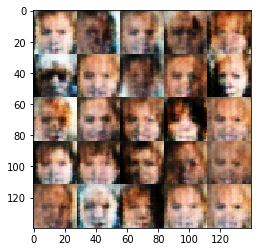

Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.7454
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.4792... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.7428
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.7245


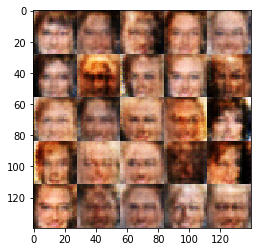

Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.7791
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.7577


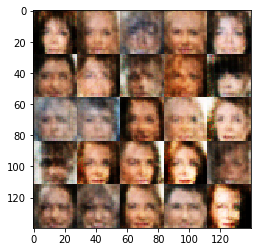

Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.7879
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.7193
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.7767


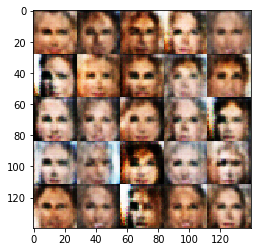

Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.8263
Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.7402
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.7719
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.7791
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.7294
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.7820


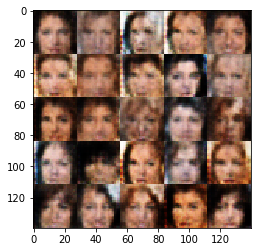

Epoch 1/1... Discriminator Loss: 1.4484... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.7791


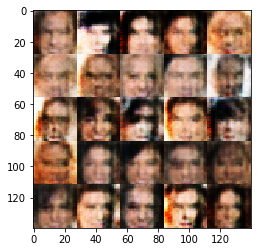

Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.7181
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.8076
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.7925
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.7758


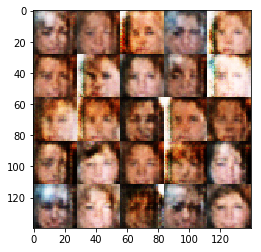

Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.7042


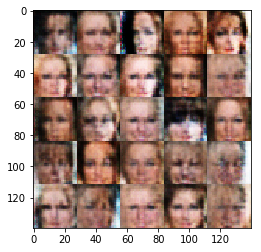

Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.7628
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.7344


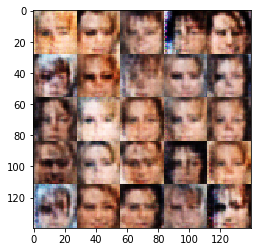

Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.7269
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.7081


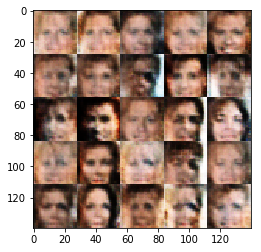

Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.7475


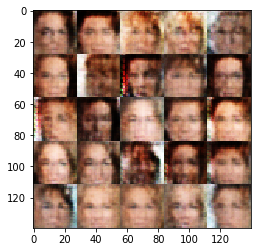

Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.7539
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.7530
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.7639
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.7403


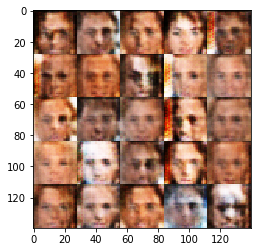

Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.7882


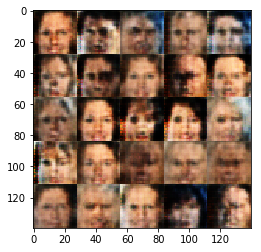

Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.7765
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.7502
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.7547


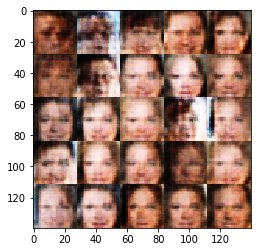

Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.7062
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.7718


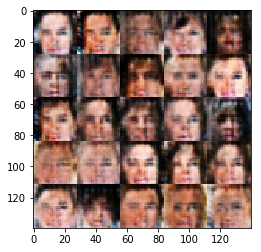

Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.7193
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.7020


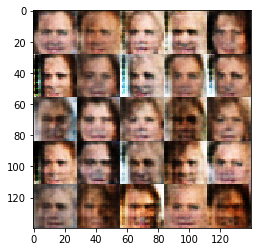

Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.7378
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7787


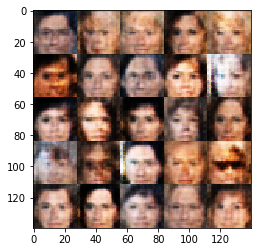

Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.7935


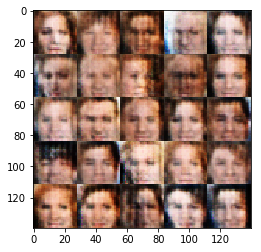

Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.7691


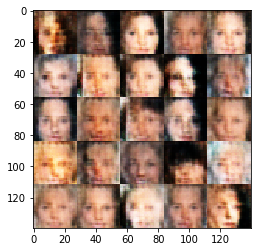

Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.7239
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.7401


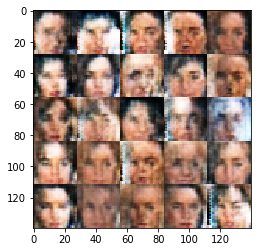

Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.7956


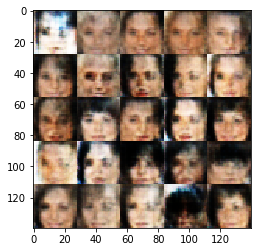

Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.7807
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.7754


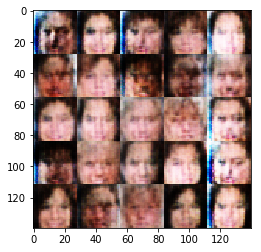

Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.7640


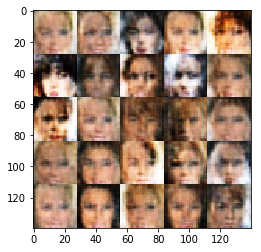

Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.7534


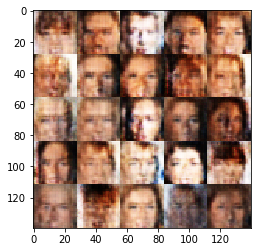

Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.7532
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.3987... Generator Loss: 0.7545


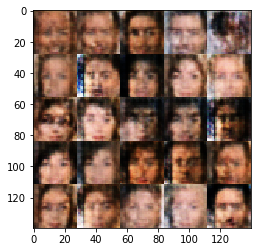

Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.7290
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.7489
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.7322
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.7708


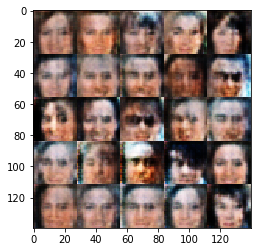

Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.7555
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.7399


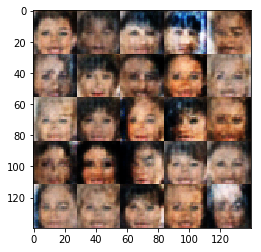

Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.7599


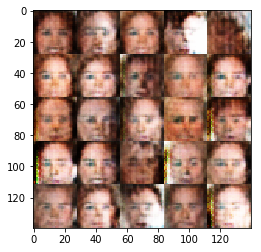

Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.7637
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.7475


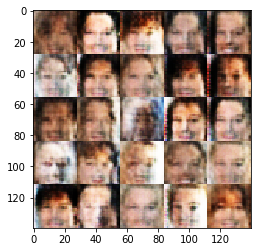

Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.7862


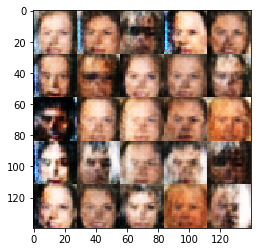

Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.7866


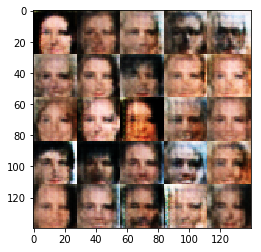

Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.7196


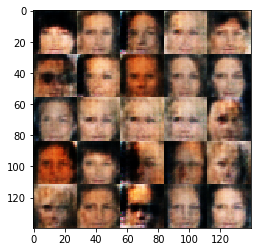

Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.7498
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.8055


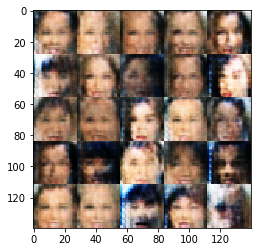

Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.8205
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.6888
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.7326


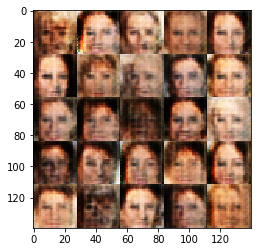

Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.7498
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.7506


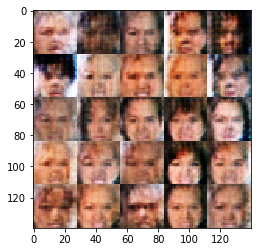

Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.7896


In [26]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.